<a href="https://www.kaggle.com/code/fellahabdelnour13/research-articles-venue-classification?scriptVersionId=269708301" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family:verdana;font-size:3.5rem;text-align:center;">
    Articles Venue Classification
</div>

<h1 style="font-family:verdana;" > Overview </h1>

- [Introduction](#intro)
- [Necessary Packages](#necessary_packages)
- [Constants](#constants)
- [Explanatory Data Analysis (EDA)](#eda)
    - [Load The Data](#load_the_data)
    - [Basic EDA](#basic_eda)
    - [Visualizations](#vis)
- [Data Preprocessing](#data_preprocessing)
    - [Remove unlabled & multi-labled row](remove_unlabled_multilabled)
    - [Text Cleaning](#text_cleaning)
    - [Data Splitting](#data_splitting)
- [Modeling & Training](#modeling_training)
    - [Utils](#utils)
    - [Basic Feature Extraction : Count Vectorizer & TF-IDF](#cv_tfidf)
    - [Incorperating Keywords & Teams](#keywords_teams)
    - [Compare All the models on the test set](#compare)
- [Conclusion](#conclusion)

<div id="intro" >
    <h1 style="font-family:verdana;" > Introduction </h1>
</div>

This notebook aims to serve as an example on what can be done with [The Research-Articles Dataset](https://www.kaggle.com/datasets/fellahabdelnour13/articles-classification-dataset) as well as an example of <br/>
how external set features can be combained with text-based features in a single classification pipeline using **sklearn** <br/>
introducing along the way basic text-cleaning/preprocessing as well as visualization techniques.

<div id="necessary_packages" >
    <h1 style="font-family:verdana;" > Necessary Packages </h1>
</div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import nltk
import re
import torch
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from functools import reduce
from wordcloud import WordCloud
from typing import Optional
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [2]:
tqdm.pandas()

In [3]:
px.defaults.template = "seaborn"

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

<h1 style="font-family:verdana;" id="constants" > Constants </h1>

In [5]:
DATA_DIR = "/kaggle/input/articles-classification-dataset"
DATA_PATH = os.path.join(DATA_DIR, "data.raw.json")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

<div id="eda">
    <h1 style="font-family:verdana;" > Explanatory Data Analysis (EDA) </h1>
</div>

<div id="load_the_data" >
    <h2 style="font-family:verdana;" > Load The Data </h2>
</div>

In [6]:
data = pd.read_json(DATA_PATH)

<div id="basic_eda" >
    <h2 style="font-family:verdana;" id="necessary_packages" > Basic EDA </h2>
</div>

- Examine the number of rows & columns

In [7]:
print(f"Dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

Dataset has 22134 rows and 8 columns.


- Examine column names, types and missing values

In [8]:
data.columns

Index(['id', 'title', 'abstract', 'keywords', 'authors', 'venue', 'date',
       'teams'],
      dtype='object')

In [9]:
data.dtypes

id                        int64
title                    object
abstract                 object
keywords                 object
authors                  object
venue                    object
date        datetime64[ns, UTC]
teams                    object
dtype: object

In [10]:
data.isna().sum(0)

id          0
title       0
abstract    0
keywords    0
authors     0
venue       0
date        0
teams       0
dtype: int64

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 No missing values are found.
</div>

- Examine the head and the tail of the dataset

In [11]:
data.head().transpose()

,0,1,2,3,4
id,5096000,5113219,5129109,5129157,5116799
title,Diffusion-based spectral super-resolution of t...,Ambiances. A Sensitivity to Ordinary Situations,Sensory Urban Mobilities: Experiences and Uses...,Preprint_Extended / disabled bodies &amp; atmo...,Comparison of GNSS LOS/NLOS Labeling Technique...
abstract,Third octave spectral recording of acoustic se...,"How do ambiances shape our sensory, social, an...",Beyond documenting all the sensory effects of ...,As much as a symbolic construction or an objec...,The distinction between Line-of-Sight (LOS) an...
keywords,"[speech privacy, generative audio, acoustic se...","[ambiance, atmosphere, ambiances, atmospheres,...","[mobilité urbaine, perception sensible, transp...","[ambiances, criticism, disabled bodies, forms ...","[gnss, satellite visibility, losnlos, sky view..."
authors,"[Modan Tailleur, Chaymae Benaatia, Mathieu Lag...","[Jean-Paul Thibaud, Nicolas Tixier, David Zerbib]",[Damien Masson],[Rachel Thomas],"[Benjamin Beaucamp, Thomas Leduc, Myriam Servi..."
venue,[info.info-ai],"[shs.archi, sde.es, shs, shs.art]",[shs.archi],[shs],[info.info-ts]
date,2025-09-08 00:00:00+00:00,2025-09-08 00:00:00+00:00,2025-07-01 00:00:00+00:00,2025-05-11 00:00:00+00:00,2025-04-28 00:00:00+00:00
teams,"[AAU, LS2N]",[AAU],[AAU],[AAU],[AAU]


In [12]:
data.tail().transpose()

,22129,22130,22131,22132,22133
id,2695371,929575,2341077,2328602,2716128
title,Predictive modelling approach applied to spoil...,Citrate lyases of lactic acid bacteria,The role of oxygen limitation in the resistanc...,Agar-entrapped bacteria as an in vitro model o...,[Retracted] R plasmid in Escherichia coli O103...
abstract,Growth of Penicillium brevicompactum was exami...,Citrate lyase is a key enzyme of the citrate m...,Viable cells of Escherichia coli were entrappe...,A simple in vitro system was developed as a mo...,"One rabbit pathogenic Escherichia coli strain,..."
keywords,[],"[citrate, citrate lyase, leuconostoc, lactic a...","[antibiotics, oxygen, alveolar ventilation fun...","[biofilm, cell immobilization, latamoxef, susc...",[]
authors,"[Jeanne-Marie Membré, M. Kubaczka]","[Sadja Bekal, Charles Diviès, Hervé Prévost]","[Odile Tresse, T. Jouenne, G.-A. Junter]","[Thierry Jouenne, Odile Tresse, Guy-Alain Junter]","[Alain Reynaud, Michel M. Federighi, Dominique..."
venue,[sdv],"[sdv.aen, sdv.ida]",[sdv],[sdv],[sdv]
date,2000-01-01 00:00:00+00:00,1998-01-01 00:00:00+00:00,1995-01-01 00:00:00+00:00,1994-06-01 00:00:00+00:00,1991-01-01 00:00:00+00:00
teams,[SECALIM],[SECALIM],[SECALIM],[SECALIM],[SECALIM]


- Columns Of The Dataset

| Column    | Description |
| -------- | ------- |
| id  | A unique identifier    |
| title | the title of the article     |
| abstract    | the abstract of the article    |
| keywords | The set of keywords associated with the article
| authors | The article's authors |
| venue | A set of categories like : math, computer science...etc
| date | The date of publication in ISO 8601 format |
| Teams | The set of teams associated with the articles' authors

- Examine Duplicates

In [13]:
print(f"There is {data.duplicated(subset=['id']).sum()} duplicate rows.")

There is 0 duplicate rows.


<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 No duplicated rows are found.
</div>

<div id="vis">
    <h2 style="font-family:verdana;" > Visualizations </h2>
</div>

### Date

In [14]:
year = data['date'].apply(lambda x : x.year).value_counts()
YEAR = 2000
n = year.iloc[year.index <= YEAR].sum()
year = year.drop(index=year.index[year.index <= YEAR])
year.index = year.index.astype(str)
year.loc[f"Year <= {YEAR}"] = n

In [15]:
fig = px.bar(
    data_frame=year.reset_index(),
    x = "date",
    y = "count",
    width = 750,
    height = 550,
    text = "count"
)

fig.update_layout(
    xaxis_title = "Year",
    yaxis_title = "Frequency"
)

fig.show(renderer='iframe')

### Keywords

In [16]:
keywords = pd.Series(reduce(lambda a,b : a+b,data['keywords'].tolist())) \
    .value_counts() \
    .reset_index() 

- Visualizing the number of keywords distribution

In [17]:
fig = px.histogram(
    data_frame = data['keywords'].apply(len)
        .reset_index(),
    x = "keywords",
    width = 750,
    height = 550,
    nbins=30
)

fig.update_layout(
    xaxis_title = "Number Of Keywords",
    yaxis_title = "Number Of Articles"
)

fig.show(renderer='iframe')

- Visualizing Top 15 Keywords

In [18]:
fig = px.bar(
    data_frame=keywords.nlargest(15, columns="count").sort_values(by="count"),
    y = "index",
    x = "count",
    width = 800,
    height = 550,
    text="count"
)

fig.update_layout(
    yaxis_title = "Keyword",
    xaxis_title = "Frequency"
)

fig.show(renderer='iframe')

### Teams

In [19]:
teams = pd.Series(reduce(lambda a,b : a+b,data['teams'].tolist())) \
    .value_counts() \
    .reset_index() 

- Visualizing the distribution of number of teams per article

In [20]:
fig = px.histogram(
    data_frame = data['teams'].apply(len)
        .reset_index(),
    x = "teams",
    width = 800,
    height = 550,
    nbins=30
)

fig.update_layout(
    xaxis_title = "Number Of Teams",
    yaxis_title = "Number Of Articles"
)

fig.show(renderer='iframe')

- Visualizing The number articles per team

In [21]:
fig = px.bar(
    data_frame=teams.sort_values(by="count"),
    y = "index",
    x = "count",
    width = 800,
    height = 550,
    text="count"
)

fig.update_layout(
    yaxis_title = "Team",
    xaxis_title = "Frequency"
)

fig.show(renderer='iframe')

### Venue

- Extract Venues : Each article has a list venues (subjects, fields of study) encoded the following way : venune-lvl1.venue-lvl2...etc <br/>
forming an hierarchy. 

In [22]:
def get_venues(venues : list[str]) -> list[str]:

    ### Venues are encoded as follows
    ### venue-lvl1.venue-lvl2...etc
    sub_venues = []

    for venue in venues:

        for sub_venue in venue.split('.'):
            
            if len(sub_venues) == 0:
                sub_venues.append(sub_venue)
            else:
                sub_venues.append(sub_venues[-1]+'.'+sub_venue)

    return list(set(sub_venues))

In [23]:
venue = pd.Series(reduce(lambda a,b : a+b,data['venue'].apply(get_venues).tolist())) \
    .value_counts() \
    .reset_index() \
    .rename(columns = { "index" : "Venue", "count" : "Frequency" })

venue['Level'] = venue["Venue"].apply(lambda x : len(x.split('.')))

In [24]:
venue.head()

,Venue,Frequency,Level
0,spi,8179,1
1,info,6273,1
2,chim,1943,1
3,phys,1774,1
4,spi.meca,1644,2


- Bar plot of main venues

In [25]:
fig = px.bar(
    data_frame = venue[venue["Level"] == 1].sort_values("Frequency"),
    y = "Venue",
    x = "Frequency",
    width = 800,
    height = 550,
    text="Frequency"
)

fig.update_layout(
    yaxis_title = "Venue",
    xaxis_title = "Number Of Articles"
)

fig.show(renderer='iframe')

- Top 15 venues from different levels

In [26]:
fig = px.bar(
    data_frame = venue[venue["Level"] == 2].nlargest(15, "Frequency")
        .sort_values("Frequency"),
    y = "Venue",
    x = "Frequency",
    width = 800,
    height = 550,
    text="Frequency"
)

fig.update_layout(
    yaxis_title = "Venue",
    xaxis_title = "Number Of Articles"
)

fig.show(renderer='iframe')

In [27]:
fig = px.bar(
    data_frame = venue[venue["Level"] == 3].nlargest(15, "Frequency")
        .sort_values("Frequency"),
    y = "Venue",
    x = "Frequency",
    width = 800,
    height = 550,
    text="Frequency"
)

fig.update_layout(
    yaxis_title = "Venue",
    xaxis_title = "Number Of Articles"
)

fig.show(renderer='iframe')

In [28]:
fig = px.bar(
    data_frame = venue[venue["Level"] == 4].nlargest(15, "Frequency")
        .sort_values("Frequency"),
    y = "Venue",
    x = "Frequency",
    width = 800,
    height = 550,
    text="Frequency"
)

fig.update_layout(
    yaxis_title = "Venue",
    xaxis_title = "Number Of Articles"
)

fig.show(renderer='iframe')

In [29]:
fig = px.bar(
    data_frame = venue[venue["Level"] == 5].nlargest(15, "Frequency")
        .sort_values("Frequency"),
    y = "Venue",
    x = "Frequency",
    width = 800,
    height = 550,
    text="Frequency"
)

fig.update_layout(
    yaxis_title = "Venue",
    xaxis_title = "Number Of Articles"
)

fig.show(renderer='iframe')

### Text Data : Title & Abstract

One of the popular and easiest way to visualize textual data is to use the worldcloud plot which is a plot <br/>
that displays words in different sizes based on their frequency in the corpus.

- Wordclouds

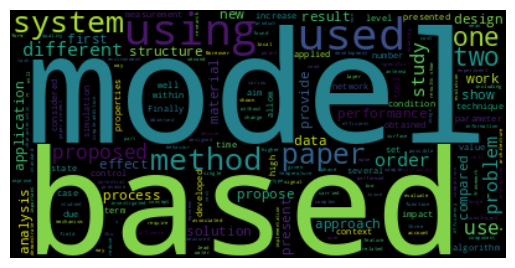

In [30]:
text = ' '.join(data.abstract)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

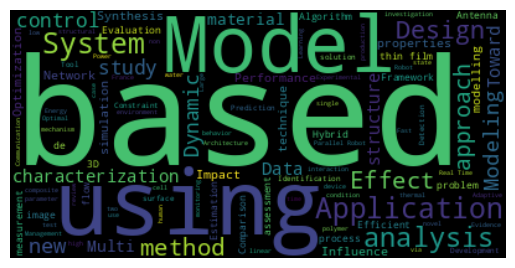

In [31]:
text = ' '.join(data.title)

wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Wordclouds by venue :

We will be using vues of level 0 as our label and it useful to visualize the wordcloud for <br/>
each label separately.

In [32]:
def get_main_venue(venues : list[str]) -> Optional[list[str]]:

    if len(venues) > 0:
        return list(set([venue.split('.')[0] for venue in venues]))
    else:
        return None

In [33]:
data['label'] = data['venue'].apply(get_main_venue)

In [34]:
unique_labels = set(reduce(lambda a,b : a + b, data['label'].dropna()))
print(f"There are a total of {len(unique_labels)} labels.")

There are a total of 15 labels.


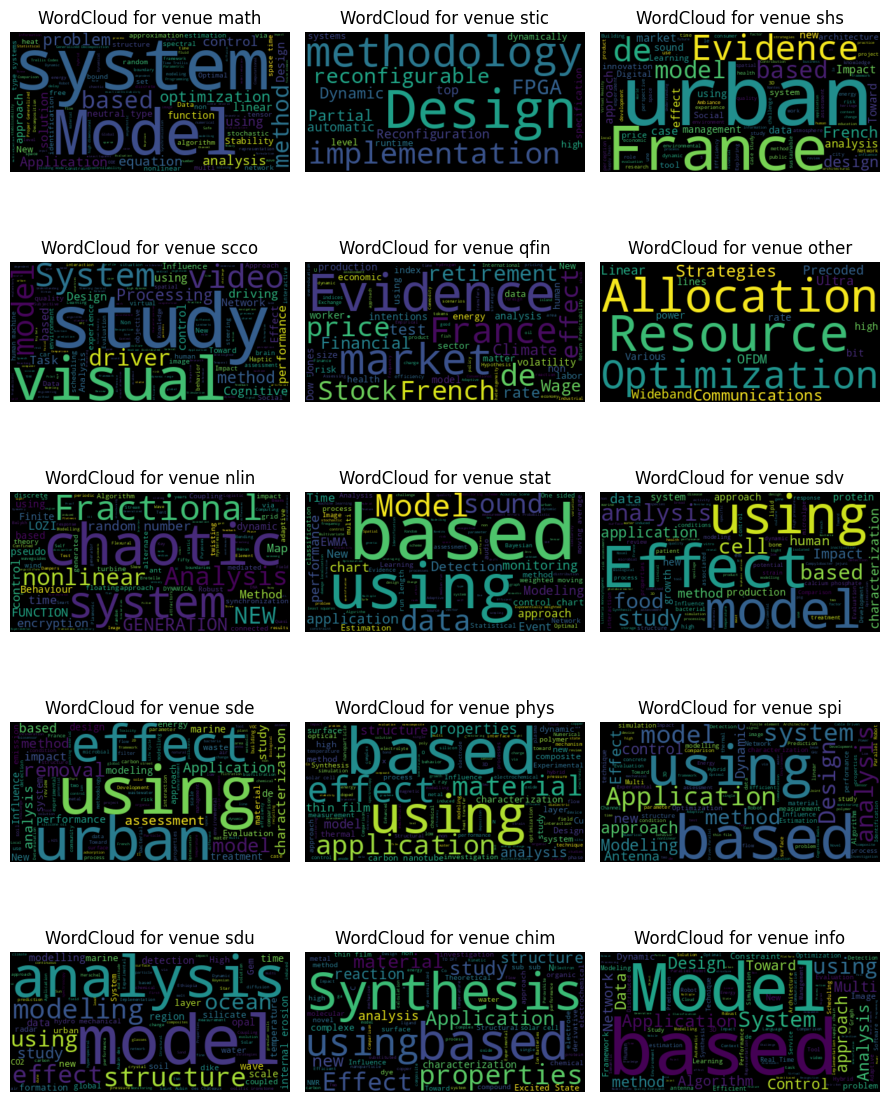

In [35]:
fig, axes = plt.subplots(nrows = 5, ncols = 3)

for i,label in enumerate(unique_labels):

    j = i // 3
    k = i % 3

    text = ' '.join(data[data['label'].apply(lambda x : x is not None and label in x)].title)
    wordcloud = WordCloud().generate(text)

    axes[j,k].imshow(wordcloud, interpolation='bilinear')
    axes[j,k].axis("off")
    axes[j,k].set_title(f"WordCloud for venue {label}")

fig.set_size_inches(9, 12)
plt.tight_layout()
plt.show()

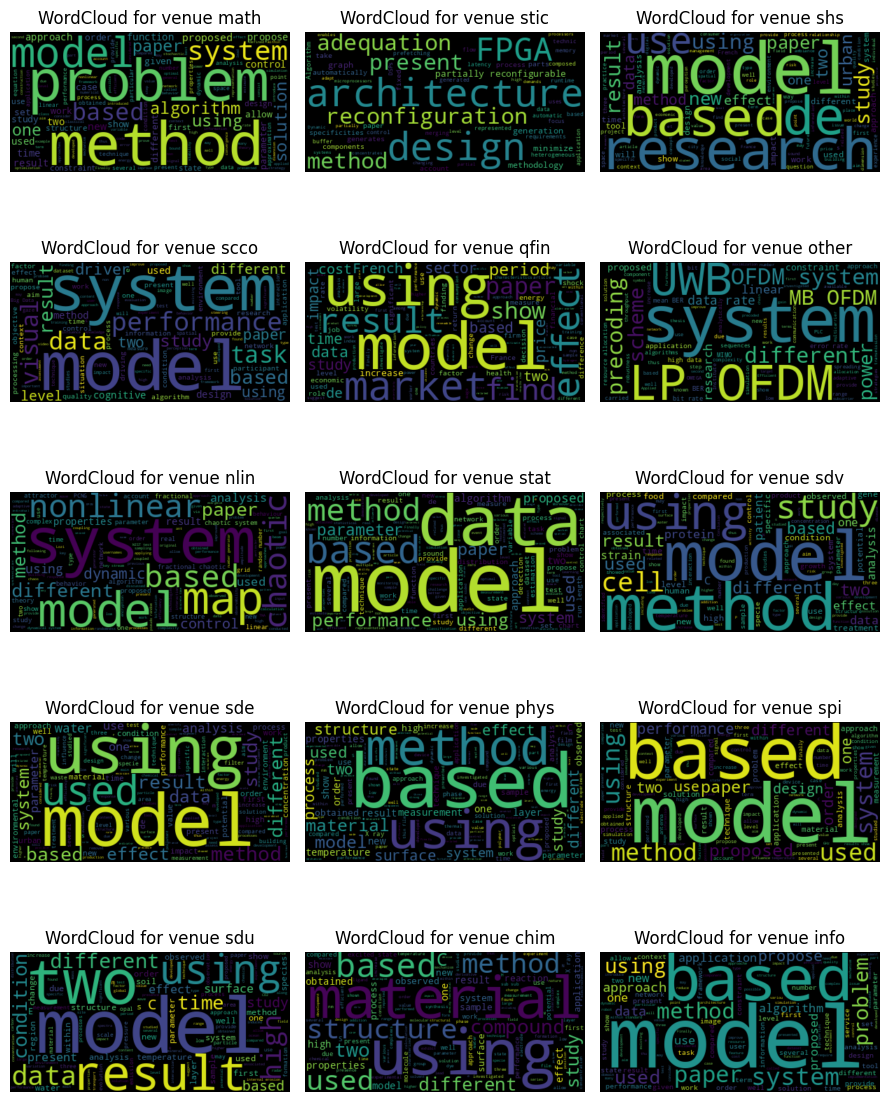

In [36]:
fig, axes = plt.subplots(nrows = 5, ncols = 3)

for i,label in enumerate(unique_labels):

    j = i // 3
    k = i % 3

    text = ' '.join(data[data['label'].apply(lambda x : x is not None and label in x)].abstract)
    wordcloud = WordCloud().generate(text)

    axes[j,k].imshow(wordcloud, interpolation='bilinear')
    axes[j,k].axis("off")
    axes[j,k].set_title(f"WordCloud for venue {label}")

fig.set_size_inches(9, 12)
plt.tight_layout()
plt.show()

<div id="data_preprocessing" >
    <h1 style="font-family:verdana;" > Data Preprocessing </h1>
</div>

<div id="remove_unlabled_multilabled" >
    <h2 style="font-family:verdana;" > Remove unlabed & multi-labled rows </h2>
</div>

We will remove unlabled datapoints and for simplicity we will also get rid of articles with more than one label <br/>
we will also remove rare labels (<50 samples)


In [37]:
print(f"There is a total of {data['label'].isna().sum()} unlabled example.")

There is a total of 291 unlabled example.


In [38]:
data['label'].dropna().apply(len).value_counts()

label
1    17666
2     3687
3      424
4       59
5        7
Name: count, dtype: int64

In [39]:
def prepare_data(data : pd.DataFrame) -> pd.DataFrame:

    ### Drop unlabled datapoints
    data = data.dropna()

    ### Drop datapoints with more than one label
    data = data[data['label'].apply(len) == 1]
    data['label'] = data['label'].apply(lambda x : x[0])

    ### Drop rare columns
    labels = data['label'].value_counts()
    labels = labels.index[labels >= 50]
    data = data[data['label'].isin(labels)]

    return data

In [40]:
prepared_data = prepare_data(data)

In [41]:
prepared_data['label'].value_counts()

label
spi     6869
info    4871
chim    1617
phys    1466
shs     1102
sdv     1012
sde      208
math     166
scco     113
sdu       90
qfin      85
stat      53
Name: count, dtype: int64

In [42]:
print(f"Dataset contains {prepared_data.shape[0]} rows.")

Dataset contains 17652 rows.


In [43]:
fig = px.bar(
    data_frame = prepared_data["label"].value_counts()
        .reset_index()
        .rename(columns={ "label" : "Label", "count" : "Frequency" })
        .sort_values("Frequency"),
    y = "Label",
    x = "Frequency",
    width=800,
    height=550,
    text="Frequency"
)

fig.show(renderer='iframe')

<div id="text_cleaning" >
    <h2 style="font-family:verdana;" > Text Cleaning </h2>
</div>

#### Quick Reminder of popular text-clearning & pre-processing techniques : 

Example : 

> "Hey @JohnDoe! 😊 Can't believe we're going to the park this evening! www.example.com #Excited 🚀"

| **Step**                     | **Description**                                                                                   | **Transformed Sentence**                                                                                     |
|-------------------------------|---------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| **1. Lowercasing**            | Converts all characters to lowercase.                                                            | "hey @johndoe! 😊 can't believe we're going to the park this evening! www.example.com #excited 🚀"          |
| **2. Removing punctuations and numbers** | Removes punctuation marks (e.g., `!`, `?`, `.`) and numbers.                                  | "hey johndoe 😊 cant believe were going to the park this evening wwwexamplecom excited 🚀"                  |
| **3. Removing extra spaces**  | Replaces multiple spaces with a single space.                                                    | "hey johndoe 😊 cant believe were going to the park this evening wwwexamplecom excited 🚀"                  |
| **4. Handling urls, mentions and hashtags** | Replaces URLs, mentions, and hashtags with placeholders like `<URL>`, `<MENTION>`, `<HASHTAG>`. | "hey <MENTION> 😊 cant believe were going to the park this evening <URL> <HASHTAG> 🚀"                      |
| **5. Handling Emojis & emoticons** | Replaces emojis and emoticons with their text descriptions or placeholders.                       | "hey <MENTION> [smiley_face] cant believe were going to the park this evening <URL> <HASHTAG> [rocket]"    |
| **6. Remove contractions**    | Expands contractions into their full form (e.g., can't $\to$ can not).                                                       | "hey <MENTION> [smiley_face] cannot believe we are going to the park this evening <URL> <HASHTAG> [rocket]" |
| **7. Handling abbreviations** | Replaces abbreviations with their full forms (e.g., "e.g." → "for example").                     | "hey <MENTION> [smiley_face] cannot believe we are going to the park this evening <URL> <HASHTAG> [rocket]" |
| **8. Removing stop-words**    | Removes common stop-words like "the", "is", "are", etc.                                          | "hey <MENTION> [smiley_face] cannot believe going park evening <URL> <HASHTAG> [rocket]"                   |
| **9. Stemming and lemmatization** | Reduces words to their root form (e.g., "going" → "go").                                            | "hey <MENTION> [smiley_face] cannot believe go park evening <URL> <HASHTAG> [rocket]"                      |
| **10. Tokenization**          | Splits the sentence into individual tokens (words, emojis, placeholders, etc.).                  | `["hey", "<MENTION>", "[smiley_face]", "cannot", "believe", "go", "park", "evening", "<URL>", "<HASHTAG>", "[rocket]"]` |

In [44]:
class Processor:

    def __init__(self):
        self.stopwords = set(nltk.corpus.stopwords.words("english"))
        self.stemmer = nltk.stem.SnowballStemmer("english")

    def __call__(self, text : str) -> str:

        text = text.lower() # Lowercase
        text = text.replace('-', ' ') # Replace hyphens with spaces
        text = re.sub(r"\$.*?\$", "", text) # Replace LaTeX equations
        text = re.sub(r"[^a-zA-Z0-9\s]", " ", text) # Remove special characters
        text = re.sub(r"\d+", " ", text) # Remove digits
        text = re.sub(r"\s+", " ", text) # Remove extra whitespaces
        text = nltk.word_tokenize(text) # Tokenize
        text = [word for word in text if word not in self.stopwords] # Remove stopwords
        text = [self.stemmer.stem(word) for word in text if word] # Stem words
        text = " ".join(text)

        return text

In [45]:
processor = Processor()

- Example

In [46]:
sample = prepared_data.title[0]
print(sample)

Diffusion-based spectral super-resolution of third octave acoustic sensor data: is privacy at risk ?


In [47]:
print(processor(sample))

diffus base spectral super resolut third octav acoust sensor data privaci risk


- Process the whole dataset

In [48]:
prepared_data['processed_title'] = prepared_data['title'].progress_apply(processor)
prepared_data['processed_abstract'] = prepared_data['abstract'].progress_apply(processor)
prepared_data['text'] = prepared_data['processed_title'] + ' ' + prepared_data['processed_abstract']

100%|██████████| 17652/17652 [00:32<00:00, 549.72it/s]


<div id="data_splitting" >
    <h2 style="font-family:verdana;" > Data Splitting </h2>
</div>

In [49]:
X = prepared_data.drop(columns='label')
y = prepared_data['label'].to_numpy()

label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

indices = np.arange(len(y))
train_indices, test_indices = train_test_split(indices, test_size=0.2, shuffle=True, stratify=y)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, shuffle=True, stratify=y[train_indices])

print(f"Number of Training Sample : {len(train_indices)}")
print(f"Number of Validation Sample : {len(val_indices)}")
print(f"Number of Test Sample : {len(test_indices)}")

Number of Training Sample : 10590
Number of Validation Sample : 3531
Number of Test Sample : 3531


<div id="modeling_training" >
    <h1 style="font-family:verdana;" > Modeling & Training </h1>
</div>

<div id="utils" >
    <h2 style="font-family:verdana;" > Utils </h2>
</div>

In [50]:
MODELS = {}

In [51]:
def train(
    models : dict[str, Pipeline],
    X_train : pd.Series | pd.DataFrame,
    y_train : np.ndarray
) -> None:
    
    for model_name, model in models.items():
        print(f"Training Model : {model_name}")
        model.fit(X_train, y_train)

In [52]:
def evaluate(
    models : dict[str, Pipeline],
    X_val : pd.Series | pd.DataFrame,
    y_val : np.ndarray
) -> pd.DataFrame:
    
    records = []
    
    for model_name, model in models.items():

        print(f"Evaluating Model : {model_name}")

        y_val_hat = model.predict_proba(X_val)
        y_val_hard = y_val_hat.argmax(-1)

        records.append({
            "Model" : model_name,
            "Accuracy" : accuracy_score(y_val, y_val_hard),
            "Macro F1 Score" : f1_score(y_val, y_val_hard, average="macro"),
            "AUC OVR" : roc_auc_score(y_val, y_val_hat, multi_class="ovr"),
            "AUC OVO" : roc_auc_score(y_val, y_val_hat, multi_class="ovo")
        })

    return pd.DataFrame(records)

In [53]:
def plot_metric(metrics_df : pd.DataFrame, metric : str) -> None:

    fig = px.bar(
        data_frame=metrics_df.sort_values(by=metric),
        x = "Model",
        y = metric,
        width = 800,
        height = 550,
        text=[f'{int(10000 * i) / 100}%' for i in metrics_df.sort_values(by=metric)[metric]]
    )

    fig.show(renderer='iframe')

<div id="cv_tfidf" >
    <h2 style="font-family:verdana;" > Basic Feature Extraction : Count Vectorizer & TF-IDF </h2>
</div>

First we will investigate the predivtive power of text features by comparing two classic feature <br/>
extraction techniques : **Bag-Of-Words (BoW)** and **TF-IDF**.

- **Bag-Of-Words (BoW)** : a way to represent text for machine learning by counting the frequency of words in a document, while completely ignoring their order and grammar.

<p align="center">
<img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/BoW.png" alt="image">
</p>

- **TF-IDF** : Term Frequency-Inverse Document Frequency, another statistical method similar to **Bag-Of-Words** <br/>
but it also considers the occurence of a word in all documents to compute its weight such that too common words <br/>
don't bias the training, it generally outpreforms **BoW**.

<p align="center">
<img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/tf-idf.png" style="width:900px;height:450px;" >
</p>

**Bag of N-GRAMS** : A variant of **BoW** that aims at considering the order of words by considering sub-sequences of <br/>
length N instead of indivisual words.

<p align="center">
    <img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/ngram.png" />
</p>

In [54]:
lcl_models = {}

In [55]:
lcl_models["cv"] = Pipeline(
    [
        (
            'FeatureExtraction',
            ColumnTransformer([
                (
                    "ColumnSelector",
                    Pipeline([
                        ("SelectCol", FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                        ("FeatureExtraction", CountVectorizer()),
                        ("DimensialityReduction", TruncatedSVD(n_components=384)),
                    ]),
                    make_column_selector(pattern='text')
                )
            ])
        ),
        ("Estimator", XGBClassifier())
    ]
)

In [56]:
lcl_models["tfidf"] = Pipeline(
    [
        (
            'FeatureExtraction',
            ColumnTransformer([
                (
                    "ColumnSelector",
                    Pipeline([
                        ("SelectCol", FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                        ("FeatureExtraction", TfidfVectorizer()),
                        ("DimensialityReduction", TruncatedSVD(n_components=384)),
                    ]),
                    make_column_selector(pattern='text')
                )
            ])
        ),
        ("Estimator", XGBClassifier())
    ]
)

In [57]:
lcl_models["cv_ngram"] = Pipeline(
    [
        (
            "ColumnSelector",
            ColumnTransformer(
                [
                    (
                        "FeatureExtraction",
                        Pipeline(
                            [
                                (
                                    "SelectCol",
                                    FunctionTransformer(lambda x: x.to_numpy()[:, 0]),
                                ),
                                (
                                    "FeatureFusion",
                                    FeatureUnion(
                                        [
                                            (
                                                "FeatureExtraction",
                                                Pipeline(
                                                    [
                                                        (
                                                            "CountVectorizer",
                                                            CountVectorizer(),
                                                        ),
                                                        (
                                                            "DimensialityReduction",
                                                            TruncatedSVD(
                                                                n_components=384
                                                            ),
                                                        ),
                                                    ]
                                                ),
                                            ),
                                            (
                                                "NGRAM_2",
                                                CountVectorizer(
                                                    ngram_range=(2, 2), max_features=100
                                                ),
                                            ),
                                            (
                                                "NGRAM_3",
                                                CountVectorizer(
                                                    ngram_range=(3, 3),
                                                    max_features=50,
                                                ),
                                            ),
                                        ]
                                    ),
                                ),
                                (
                                    "DimensialityReduction",
                                    TruncatedSVD(n_components=384),
                                ),
                            ]
                        ),
                        make_column_selector(pattern="text"),
                    )
                ]
            ),
        ),
        ("Estimator", XGBClassifier()),
    ]
)

In [58]:
lcl_models["tfidf_ngram"] = Pipeline(
    [
        (
            "ColumnSelector",
            ColumnTransformer(
                [
                    (
                        "FeatureExtraction",
                        Pipeline(
                            [
                                (
                                    "SelectCol",
                                    FunctionTransformer(lambda x: x.to_numpy()[:, 0]),
                                ),
                                (
                                    "FeatureFusion",
                                    FeatureUnion(
                                        [
                                            (
                                                "FeatureExtraction",
                                                Pipeline(
                                                    [
                                                        (
                                                            "TF-IDF",
                                                            TfidfVectorizer(),
                                                        ),
                                                        (
                                                            "DimensialityReduction",
                                                            TruncatedSVD(
                                                                n_components=384
                                                            ),
                                                        ),
                                                    ]
                                                ),
                                            ),
                                            (
                                                "NGRAM_2",
                                                CountVectorizer(
                                                    ngram_range=(2, 2), max_features=100
                                                ),
                                            ),
                                            (
                                                "NGRAM_3",
                                                CountVectorizer(
                                                    ngram_range=(3, 3),
                                                    max_features=50,
                                                ),
                                            ),
                                        ]
                                    ),
                                )                            
                            ]
                        ),
                        make_column_selector(pattern="text"),
                    )
                ]
            ),
        ),
        ("Estimator", XGBClassifier()),
    ]
)

In [59]:
train(lcl_models, prepared_data.iloc[train_indices], y[train_indices])

Training Model : cv
Training Model : tfidf
Training Model : cv_ngram
Training Model : tfidf_ngram


In [60]:
eval_df = evaluate(lcl_models, prepared_data.iloc[val_indices], y[val_indices])
eval_df

Evaluating Model : cv
Evaluating Model : tfidf
Evaluating Model : cv_ngram
Evaluating Model : tfidf_ngram


,Model,Accuracy,Macro F1 Score,AUC OVR,AUC OVO
0,cv,0.722175,0.408652,0.892235,0.862469
1,tfidf,0.760691,0.505779,0.929169,0.904341
2,cv_ngram,0.725573,0.392750,0.895909,0.867028
3,tfidf_ngram,0.760691,0.505238,0.922469,0.903142


<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 This clearly shows <b>TF-IDF</b> superiority compared to <b>Bow</b> while <b>N-GRAM</b> Features add little to no
    constribution to the performance of the model.
</div>

In [61]:
MODELS = {**MODELS,**lcl_models}

<div id="keywords_teams" >
    <h2 style="font-family:verdana;" > Incorperating Keywords & Teams </h2>
</div>

Now we will try to incorperate keywords & teams informations as features by adding binary features indicating simply <br/>
if the article has that keyword / belongs to that team, this can be achieved by changing few parameters when instantiating <br/>
**CountVectorizer**, such technique is refered to as (bag of keywords) and it's highly applicable when dealing with sets in <br/>
machine learning and we will keep TF-IDF as the default feature extractor based on the results of the previous experiments.

In [62]:
lcl_models = {}

In [63]:
lcl_models["tfidf_keywords"] = Pipeline([
    (
        'FeatureFusion',
        FeatureUnion([
            (
                "Keywords",
                ColumnTransformer([
                    (
                        "FeatureExtraction",
                        Pipeline([
                            ('SelectCol', FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                            (
                                "FeatureExtraction",
                                CountVectorizer(
                                    preprocessor=lambda x : [keyword.strip().lower() for keyword in x], # Manual Lowercasing
                                    tokenizer=lambda x : x, # We have a list not a text, and we want to treat each keyword as its own token
                                    binary=True, # We only want binary flags
                                    token_pattern=None, # Since it's not used 
                                    min_df=5 # Only Consider keywords that occur a minimum of 5 times
                                )
                            ),
                            ('DimensialityReduction', TruncatedSVD(n_components=128)),
                        ]),
                        make_column_selector(pattern="keywords") # Only applied to keywords column
                    )
                ])
            ),
            (
                'Text',
                ColumnTransformer([
                    (
                        'FeatureExtraction',
                        Pipeline([
                            ('SelectCol', FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                            ('FeatureExtraction', TfidfVectorizer()),
                            ('DimensialityReduction', TruncatedSVD(n_components=384)),
                        ]),
                        make_column_selector(pattern="text") # Only applied to Test
                    )
                ])
            )
        ])
    ),
    ('Estimator', XGBClassifier())
])

In [64]:
lcl_models["tfidf_teams"] = Pipeline([
    (
        'FeatureFusion',
        FeatureUnion([
            (
                "Teams",
                ColumnTransformer([
                    (
                        "FeatureExtraction",
                        Pipeline([
                            ('SelectCol', FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                            (
                                "FeatureExtraction",
                                CountVectorizer(
                                    preprocessor=lambda x : [keyword.strip().lower() for keyword in x], # Manual Lowercasing
                                    tokenizer=lambda x : x, # We have a list not a text, and we want to treat each team as its own token
                                    binary=True, # We only want binary flags
                                    token_pattern=None, # Since it's not used 
                                )
                            ),
                        ]),
                        make_column_selector(pattern="teams") # Only applied to teams column
                    )
                ])
            ),
            (
                'Text',
                ColumnTransformer([
                    (
                        'FeatureExtraction',
                        Pipeline([
                            ('SelectCol', FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                            ('FeatureExtraction', TfidfVectorizer()),
                            ('DimensialityReduction', TruncatedSVD(n_components=384)),
                        ]),
                        make_column_selector(pattern="text") # Only applied to Test
                    )
                ])
            )
        ])
    ),
    ('Estimator', XGBClassifier())
])

In [65]:
lcl_models["tfidf_keywords_teams"] = Pipeline([
    (
        'FeatureFusion',
        FeatureUnion([
            (
                "Teams",
                ColumnTransformer([
                    (
                        "FeatureExtraction",
                        Pipeline([
                            ('SelectCol', FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                            (
                                "FeatureExtraction",
                                CountVectorizer(
                                    preprocessor=lambda x : [keyword.strip().lower() for keyword in x], # Manual Lowercasing
                                    tokenizer=lambda x : x, # We have a list not a text, and we want to treat each team as its own token
                                    binary=True, # We only want binary flags
                                    token_pattern=None, # Since it's not used 
                                )
                            ),
                        ]),
                        make_column_selector(pattern="teams") # Only applied to teams column
                    )
                ])
            ),
            (
                "Keywords",
                ColumnTransformer([
                    (
                        "FeatureExtraction",
                        Pipeline([
                            ('SelectCol', FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                            (
                                "FeatureExtraction",
                                CountVectorizer(
                                    preprocessor=lambda x : [keyword.strip().lower() for keyword in x], # Manual Lowercasing
                                    tokenizer=lambda x : x, # We have a list not a text, and we want to treat each keyword as its own token
                                    binary=True, # We only want binary flags
                                    token_pattern=None, # Since it's not used 
                                    min_df=5 # Only Consider keywords that occur a minimum of 5 times
                                )
                            ),
                            ('DimensialityReduction', TruncatedSVD(n_components=128)),
                        ]),
                        make_column_selector(pattern="keywords") # Only applied to keywords column
                    )
                ])
            ),
            (
                'Text',
                ColumnTransformer([
                    (
                        'FeatureExtraction',
                        Pipeline([
                            ('SelectCol', FunctionTransformer(lambda x : x.to_numpy()[:,0])),
                            ('FeatureExtraction', TfidfVectorizer()),
                            ('DimensialityReduction', TruncatedSVD(n_components=384)),
                        ]),
                        make_column_selector(pattern="text") # Only applied to Text column
                    )
                ])
            )
        ])
    ),
    ('Estimator', XGBClassifier())
])

In [66]:
train(lcl_models, prepared_data.iloc[train_indices], y[train_indices])

Training Model : tfidf_keywords
Training Model : tfidf_teams
Training Model : tfidf_keywords_teams


In [67]:
eval_df = evaluate(lcl_models, prepared_data.iloc[val_indices], y[val_indices])
eval_df

Evaluating Model : tfidf_keywords
Evaluating Model : tfidf_teams
Evaluating Model : tfidf_keywords_teams


,Model,Accuracy,Macro F1 Score,AUC OVR,AUC OVO
0,tfidf_keywords,0.766355,0.500273,0.929065,0.909588
1,tfidf_teams,0.806004,0.536264,0.940259,0.924407
2,tfidf_keywords_teams,0.800906,0.531827,0.938641,0.921305


In [68]:
MODELS = {**MODELS,**lcl_models}

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 The impact of the teams dervied features shows as it increases the accuracy with ~4% while keyword features don't contribute to the performance.
</div>

<div id="compare" >
    <h2 style="font-family:verdana;" > Compare All the models on the test set </h2>
</div>

In [69]:
eval_df = evaluate(MODELS, prepared_data.iloc[test_indices], y[test_indices])
eval_df

Evaluating Model : cv
Evaluating Model : tfidf
Evaluating Model : cv_ngram
Evaluating Model : tfidf_ngram
Evaluating Model : tfidf_keywords
Evaluating Model : tfidf_teams
Evaluating Model : tfidf_keywords_teams


,Model,Accuracy,Macro F1 Score,AUC OVR,AUC OVO
0,cv,0.733786,0.399550,0.905443,0.877195
1,tfidf,0.770320,0.498945,0.921227,0.900888
2,cv_ngram,0.734919,0.423447,0.899984,0.867331
3,tfidf_ngram,0.770320,0.494815,0.924147,0.901947
4,tfidf_keywords,0.771453,0.489102,0.924412,0.903766
5,tfidf_teams,0.806004,0.551780,0.940502,0.924157
6,tfidf_keywords_teams,0.812801,0.548013,0.943315,0.927041


In [70]:
plot_metric(eval_df, "Accuracy")

In [71]:
plot_metric(eval_df, "Macro F1 Score")

In [72]:
plot_metric(eval_df, "AUC OVO")

In [73]:
plot_metric(eval_df, "AUC OVR")

- Best Model Confusion Matrix

In [74]:
best_model = eval_df['Model'][eval_df['Macro F1 Score'].idxmax()]
print(best_model)

tfidf_teams


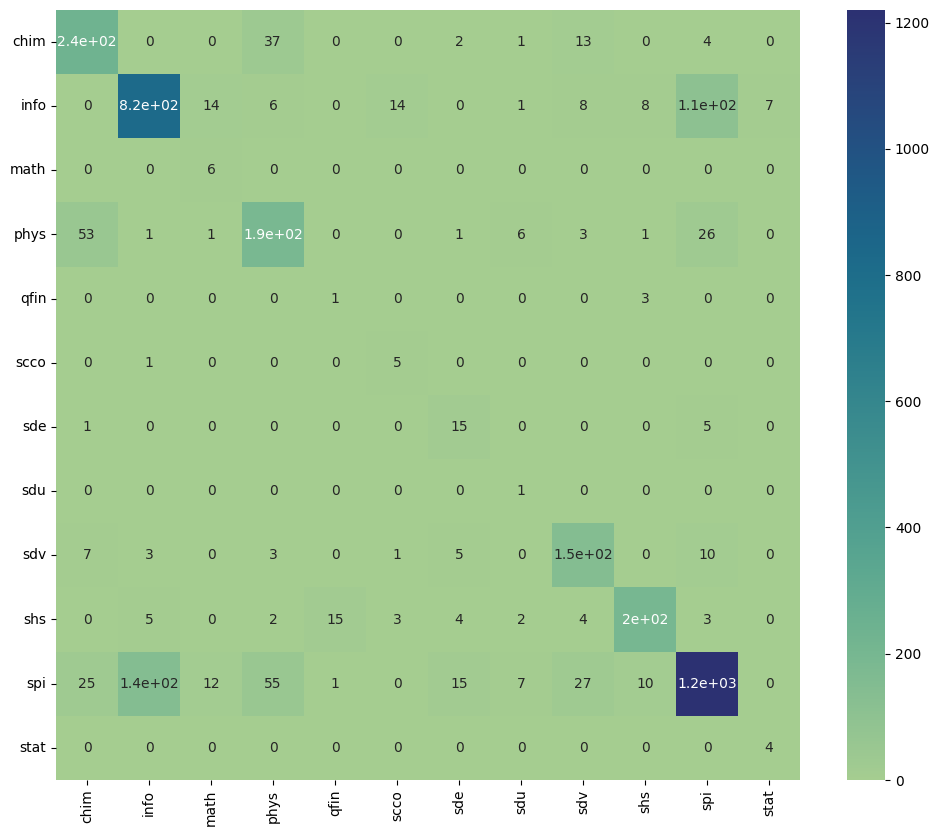

In [75]:
y_pred = MODELS[best_model].predict(prepared_data.iloc[test_indices])
cm = confusion_matrix(y_pred, y[test_indices])
cm = pd.DataFrame(data=cm,index=label_encoder.classes_,columns=label_encoder.classes_)
ax = sns.heatmap(cm, annot=True, cmap='crest')
ax.figure.set_size_inches(12, 10)

<div id="conclusion" >
    <h1 style="font-family:verdana;" > Conclusion </h1>
</div>

TFIDF + teams information and TFIDF with teams and keywords informations are the top performing model in terms Of <br />
Accuracy and F1 Score without any noticable difference, The F1 score metric is low due data imbalance <br />
it may worth investigating oversampling techniques.

<h1 style="font-family:verdana;" id="necessary_packages" > Thank You :) </h1>